---
<h1><B> Data Mining(CS5600)  </h1></B></center>

---

<table>
<tr> 
<td><h3> Assignment : </td>
<td><h3> 2 </td>
</tr>
<tr> 
<td><h3> Title : </td>
<td><h3> Citation Network Analysis </td>
</tr>
<tr> 
<td><h3> Team Details : </td>
<td>

<table>
<tr>
<th> <h3> Name </th>
<th> <h3> Roll Number </th>
</tr>



<tr> 
<td><h5> Deva Suvedh </td>
<td><h5> CS22BTECH11016 </td>
</tr>
<tr> 
<td><h5> Medikonda Sreekar </td>
<td><h5> CS22BTECH11037 </td>
<tr>
<td><h5> Gujjala Vignesh </td>
<td><h5> CS22BTECH11025 </td>
</tr>
<td><h5> Singa Divija Reddy </td>
<td><h5> AI22BTECH11026 </td>
</tr>
<td><h5> Nunavath Vishnu Teja </td>
<td><h5> AI22BTECH11030 </td>
</tr>

<table>



</td>
</tr>
<table>


## TASK 1

Scanning DBLP files for papers (2010–2015 with ≥60 citations)...


Scanning dblp.v10/dblp-ref/dblp-ref-0.json: 1000000it [00:05, 180317.83it/s]
Scanning dblp.v10/dblp-ref/dblp-ref-1.json: 1000000it [00:05, 166693.27it/s]
Scanning dblp.v10/dblp-ref/dblp-ref-2.json: 1000000it [00:06, 158997.14it/s]
Scanning dblp.v10/dblp-ref/dblp-ref-3.json: 79007it [00:00, 204608.47it/s]



✅ Eligible papers found: 49572

Building directed citation graph with metadata...


100%|██████████| 49572/49572 [00:00<00:00, 272521.54it/s]



✅ Graph construction complete!
Nodes (papers): 49572
Edges (citations): 163309

Computing connectivity statistics...

===== GRAPH STATISTICS =====
Vertices: 49572
Edges: 163309
Weakly Connected Components: 6985
Strongly Connected Components: 47731
Nodes in largest WCC: 41225
Edges in largest WCC: 161635
Nodes in largest SCC: 171
Edges in largest SCC: 1190

Visualizing a small random subgraph (100 nodes)...


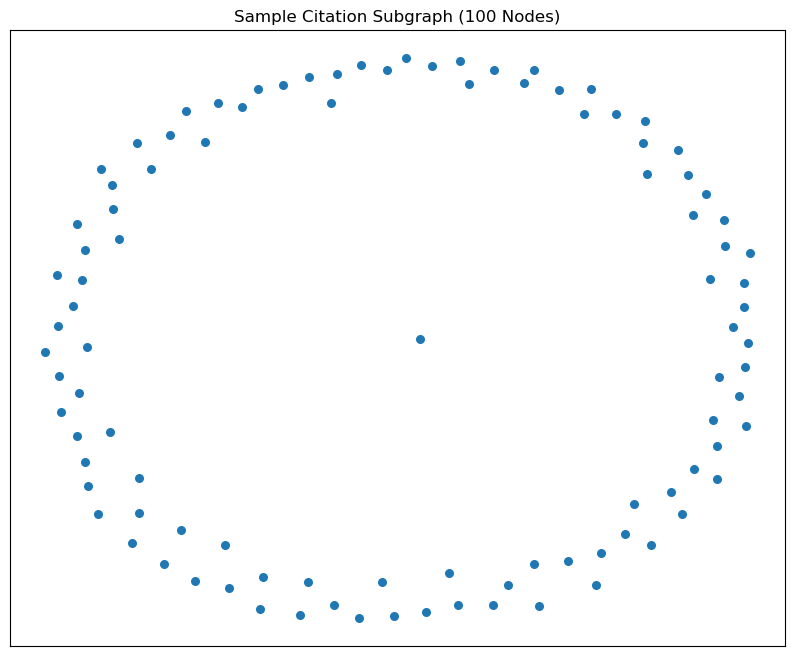


✅ Graph saved successfully as 'citation_graph_filtered.gpickle' (metadata preserved!)


In [11]:
import json
import networkx as nx
from tqdm import tqdm
import glob
import random
import matplotlib.pyplot as plt
import pickle

# -------------------------------
# 📂 Folder containing dblp-ref-*.json files
# -------------------------------
folder_path = "dblp.v10/dblp-ref/"
files = sorted(glob.glob(folder_path + "dblp-ref-*.json"))

# -------------------------------
# 1️⃣ Collect eligible papers
# -------------------------------
eligible_ids = set()
paper_meta = {}

print("Scanning DBLP files for papers (2010–2015 with ≥60 citations)...")
for file_path in files:
    with open(file_path, "r") as f:
        for line in tqdm(f, desc=f"Scanning {file_path}"):
            data = json.loads(line)
            year = data.get("year", 0)
            n_cit = data.get("n_citation", 0)
            if 2010 <= year <= 2015 and n_cit >= 60:
                pid = data.get("id")
                if not pid:
                    continue
                eligible_ids.add(pid)
                paper_meta[pid] = {
                    "title": data.get("title", ""),
                    "year": year,
                    "n_citation": n_cit,
                    "authors": data.get("authors", []),
                    "venue": data.get("venue", ""),
                    "references": data.get("references", [])
                }

print(f"\n✅ Eligible papers found: {len(eligible_ids)}")

# -------------------------------
# 2️⃣ Build directed citation graph with metadata
# -------------------------------
G = nx.DiGraph()

print("\nBuilding directed citation graph with metadata...")
for pid, meta in tqdm(paper_meta.items()):
    G.add_node(pid, **meta)

for pid, meta in paper_meta.items():
    for ref in meta.get("references", []):
        if ref in eligible_ids:
            G.add_edge(pid, ref)

print("\n✅ Graph construction complete!")
print(f"Nodes (papers): {G.number_of_nodes()}")
print(f"Edges (citations): {G.number_of_edges()}")

# -------------------------------
# 3️⃣ Compute graph statistics
# -------------------------------
print("\nComputing connectivity statistics...")
wccs = list(nx.weakly_connected_components(G))
sccs = list(nx.strongly_connected_components(G))

largest_wcc = G.subgraph(max(wccs, key=len))
largest_scc = G.subgraph(max(sccs, key=len))

stats = {
    "Vertices": G.number_of_nodes(),
    "Edges": G.number_of_edges(),
    "Weakly Connected Components": len(wccs),
    "Strongly Connected Components": len(sccs),
    "Nodes in largest WCC": largest_wcc.number_of_nodes(),
    "Edges in largest WCC": largest_wcc.number_of_edges(),
    "Nodes in largest SCC": largest_scc.number_of_nodes(),
    "Edges in largest SCC": largest_scc.number_of_edges(),
}

print("\n===== GRAPH STATISTICS =====")
for k, v in stats.items():
    print(f"{k}: {v}")

# -------------------------------
# 4️⃣ Small visualization
# -------------------------------
print("\nVisualizing a small random subgraph (100 nodes)...")
sample_nodes = random.sample(list(G.nodes()), min(100, len(G.nodes())))
H = G.subgraph(sample_nodes)

plt.figure(figsize=(10, 8))
nx.draw_networkx(H, node_size=30, arrows=False, with_labels=False)
plt.title("Sample Citation Subgraph (100 Nodes)")
plt.show()

# -------------------------------
# 5️⃣ Save graph for future tasks
# -------------------------------
with open("citation_graph_filtered.gpickle", "wb") as f:
    pickle.dump(G, f)

print("\n✅ Graph saved successfully as 'citation_graph_filtered.gpickle' (metadata preserved!)")


## TASK 2

In [12]:
# ============================
# ⚡ TASK 2 — Final (with Titles)
# ============================

import networkx as nx
import numpy as np
from scipy.sparse import csr_matrix
import pickle

# ✅ Read gpickle manually
with open("citation_graph_filtered.gpickle", "rb") as f:
    G = pickle.load(f)

print("✅ Graph loaded! Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())

# -----------------------------------------
# 1️⃣ Map paper IDs to indices
# -----------------------------------------
node_list = list(G.nodes())
node_index = {n: i for i, n in enumerate(node_list)}
n = len(node_list)

# -----------------------------------------
# 2️⃣ Build sparse adjacency matrix A
# -----------------------------------------
rows, cols = [], []
for u, v in G.edges():
    rows.append(node_index[u])
    cols.append(node_index[v])
A = csr_matrix((np.ones(len(rows), dtype=np.int8), (rows, cols)), shape=(n, n))
print("✅ Adjacency matrix built:", A.shape)

# -----------------------------------------
# 3️⃣ Compute Co-citation and Bibliographic Coupling matrices
# -----------------------------------------
C = (A.T @ A).tocsr()   # Co-citation
B = (A @ A.T).tocsr()   # Bibliographic coupling
print("✅ Matrices computed (sparse multiplication done)")

# -----------------------------------------
# 4️⃣ Extract top-10 pairs for each
# -----------------------------------------
def top_pairs_from_sparse(M, top_n=10):
    pairs = []
    M.setdiag(0)
    M.eliminate_zeros()  # works fine on CSR
    coo = M.tocoo()
    for i, j, val in zip(coo.row, coo.col, coo.data):
        if i < j:
            pairs.append(((node_list[i], node_list[j]), int(val)))
    pairs.sort(key=lambda x: x[1], reverse=True)
    return pairs[:top_n]

top_co = top_pairs_from_sparse(C)
top_bib = top_pairs_from_sparse(B)

# -----------------------------------------
# 5️⃣ Display results — print titles instead of IDs
# -----------------------------------------
def get_title(pid):
    t = G.nodes[pid].get("title")
    if t and t.strip():
        return t.strip()
    return f"(Title missing) [{pid}]"

print("\n===== 🧠 Top-10 Similar Papers (Co-Citation Score) =====")
for i, ((a, b), score) in enumerate(top_co, 1):
    print(f"{i:2d}. ({score})")
    print(f"   • {get_title(a)}")
    print(f"     ↔ {get_title(b)}\n")

print("===== 📚 Top-10 Similar Papers (Bibliographic Coupling Score) =====")
for i, ((a, b), score) in enumerate(top_bib, 1):
    print(f"{i:2d}. ({score})")
    print(f"   • {get_title(a)}")
    print(f"     ↔ {get_title(b)}\n")

print("✅ Task 2 completed successfully — titles printed!")


✅ Graph loaded! Nodes: 49572 Edges: 163309
✅ Adjacency matrix built: (49572, 49572)
✅ Matrices computed (sparse multiplication done)

===== 🧠 Top-10 Similar Papers (Co-Citation Score) =====
 1. (122)
   • Real-time human pose recognition in parts from single depth images
     ↔ Real-time human pose recognition in parts from single depth images

 2. (95)
   • Very Deep Convolutional Networks for Large-Scale Image Recognition
     ↔ ImageNet Classification with Deep Convolutional Neural Networks

 3. (91)
   • DeCAF: A Deep Convolutional Activation Feature for Generic Visual Recognition
     ↔ ImageNet Classification with Deep Convolutional Neural Networks

 4. (91)
   • Caffe: Convolutional Architecture for Fast Feature Embedding
     ↔ ImageNet Classification with Deep Convolutional Neural Networks

 5. (85)
   • OverFeat: Integrated Recognition, Localization and Detection using Convolutional Networks
     ↔ ImageNet Classification with Deep Convolutional Neural Networks

 6. (85)
   •

## TASK 3


In [13]:
# ============================
# ⚡ TASK 3 — PageRank Correlation Analysis
# ============================

import pickle
import networkx as nx
import numpy as np
from scipy.stats import pearsonr

# -----------------------------------------
# 1️⃣ Load graph (with metadata)
# -----------------------------------------
with open("citation_graph_filtered.gpickle", "rb") as f:
    G = pickle.load(f)

print("✅ Graph loaded! Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())

# -----------------------------------------
# 2️⃣ Compute in-degree (citations in the extracted subset)
# -----------------------------------------
cit_counts = dict(G.in_degree())

# -----------------------------------------
# 3️⃣ Loop over damping factors
# -----------------------------------------
alphas = np.arange(0.15, 0.96, 0.10)
results = {}
k = 50

for alpha in alphas:
    pr = nx.pagerank(G, alpha=alpha)
    # Sort nodes by PageRank
    top_pr = sorted(pr.items(), key=lambda x: x[1], reverse=True)[:k]
    top_nodes = [n for n, _ in top_pr]

    # Extract corresponding citation counts
    pr_scores = [pr[n] for n in top_nodes]
    citations = [cit_counts.get(n, 0) for n in top_nodes]

    # Pearson correlation
    corr, _ = pearsonr(pr_scores, citations)
    results[round(alpha, 2)] = corr
    print(f"α={alpha:.2f} → Pearson correlation = {corr:.4f}")

# -----------------------------------------
# 4️⃣ Identify best and worst damping factors
# -----------------------------------------
best_alpha = max(results, key=results.get)
worst_alpha = min(results, key=results.get)
print("\n✅ Best α:", best_alpha, " (corr =", results[best_alpha], ")")
print("❌ Worst α:", worst_alpha, " (corr =", results[worst_alpha], ")")

# -----------------------------------------
# 5️⃣ Helper to print top-10 papers
# -----------------------------------------
def get_title(pid):
    return G.nodes[pid].get("title", pid)

def top_papers(alpha):
    pr = nx.pagerank(G, alpha=alpha)
    top = sorted(pr.items(), key=lambda x: x[1], reverse=True)[:10]
    print(f"\n===== 🔝 Top-10 Papers (α={alpha:.2f}) =====")
    print(f"{'S.No.':<5} {'Title':<70} {'PageRank Score'}")
    for i, (pid, score) in enumerate(top, 1):
        print(f"{i:<5} {get_title(pid)[:70]:<70} {score:.6f}")

# -----------------------------------------
# 6️⃣ Show top papers for best and worst α
# -----------------------------------------
top_papers(best_alpha)
top_papers(worst_alpha)

# -----------------------------------------
# 7️⃣ Correlation summary table
# -----------------------------------------
print("\n===== 📊 Correlation Summary =====")
print(f"{'Damping Factor':<15} {'Pearson Correlation'}")
for a, c in results.items():
    print(f"{a:<15} {c:.6f}")

print("\n✅ Task 3 completed successfully!")


✅ Graph loaded! Nodes: 49572 Edges: 163309
α=0.15 → Pearson correlation = 0.7858
α=0.25 → Pearson correlation = 0.7688
α=0.35 → Pearson correlation = 0.7457
α=0.45 → Pearson correlation = 0.7323
α=0.55 → Pearson correlation = 0.7128
α=0.65 → Pearson correlation = 0.6889
α=0.75 → Pearson correlation = 0.6742
α=0.85 → Pearson correlation = 0.5542
α=0.95 → Pearson correlation = 0.6400

✅ Best α: 0.15  (corr = 0.7857552818011266 )
❌ Worst α: 0.85  (corr = 0.5541540806284978 )

===== 🔝 Top-10 Papers (α=0.15) =====
S.No. Title                                                                  PageRank Score
1     LIBSVM: A library for support vector machines                          0.000848
2     The Pascal Visual Object Classes (VOC) Challenge                       0.000275
3     Object Detection with Discriminatively Trained Part-Based Models       0.000223
4     Community detection in graphs                                          0.000160
5     Fast and Scalable Local Kernel Machines    

## TASK 4


In [14]:
# ============================
# ⚡ TASK 4 — Topic-Sensitive PageRank
# ============================

import pickle
import networkx as nx
import numpy as np

# -----------------------------------------
# 🧠 Theoretical Comparison (for report)
# -----------------------------------------
"""
🔹 Normal PageRank:
   - Uniform random surfer model.
   - All nodes are treated equally — teleportation probability is uniform.
   - PageRank(G, alpha=d): pr = d * A' * pr + (1-d) * 1/N

🔹 Topic-Sensitive PageRank:
   - Biased random surfer model.
   - Teleportation happens only to nodes related to a specific topic.
   - A separate PageRank vector is computed per topic.
   - Used for domain-specific ranking (e.g., “security papers”).

🔹 Personalized PageRank:
   - Similar to topic-sensitive, but personalization vector depends on a *user* or *set of preferred nodes*.
   - Used for recommendations (e.g., user-specific content).
"""

# -----------------------------------------
# 1️⃣ Load graph
# -----------------------------------------
with open("citation_graph_filtered.gpickle", "rb") as f:
    G = pickle.load(f)

print("✅ Graph loaded! Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())

# -----------------------------------------
# 2️⃣ Define topics
# -----------------------------------------
topics = ["security", "hashing", "streaming", "timeseries", "search"]
damping = 0.85

# -----------------------------------------
# 3️⃣ Precompute citations (in-degree)
# -----------------------------------------
cit_counts = dict(G.in_degree())

# -----------------------------------------
# 4️⃣ Helper functions
# -----------------------------------------
def get_title(pid):
    return G.nodes[pid].get("title", pid)

def topic_sensitive_pagerank(G, topic, alpha=0.85):
    topic_nodes = [n for n, data in G.nodes(data=True)
                   if topic.lower() in data.get("title", "").lower()]
    
    if not topic_nodes:
        print(f"⚠️ No papers found for topic: {topic}")
        return None, []

    # Create personalization vector (teleportation only to topic-relevant nodes)
    p = {n: 1.0 / len(topic_nodes) if n in topic_nodes else 0.0 for n in G.nodes()}
    pr = nx.pagerank(G, alpha=alpha, personalization=p)
    return pr, topic_nodes

def show_top_papers_for_topic(topic, top_n=10):
    pr, topic_nodes = topic_sensitive_pagerank(G, topic, damping)
    if pr is None:
        return

    # Sort by PageRank score
    top = sorted(pr.items(), key=lambda x: x[1], reverse=True)[:top_n]

    print(f"\n===== 🔝 Top-10 Papers for Topic: {topic.capitalize()} =====")
    print(f"{'S.No.':<5} {'Title':<70} {'PageRank Score':<18} {'Citations'}")
    for i, (pid, score) in enumerate(top, 1):
        print(f"{i:<5} {get_title(pid)[:70]:<70} {score:<18.6e} {cit_counts.get(pid, 0)}")

# -----------------------------------------
# 5️⃣ Run for all topics
# -----------------------------------------
for topic in topics:
    show_top_papers_for_topic(topic)

print("\n✅ Task 4 completed successfully!")


✅ Graph loaded! Nodes: 49572 Edges: 163309

===== 🔝 Top-10 Papers for Topic: Security =====
S.No. Title                                                                  PageRank Score     Citations
1     Security and Privacy Challenges in Cloud Computing Environments        8.956396e-03       33
2     Neutralization: new insights into the problem of employee systems secu 8.016105e-03       21
3     SecureCloud: Towards a Comprehensive Security Framework for Cloud Comp 7.317813e-03       3
4     Enabling Public Auditability and Data Dynamics for Storage Security in 6.750305e-03       47
5     Dependable and Secure Sensor Data Storage with Dynamic Integrity Assur 6.745501e-03       3
6     Stackelberg vs. Nash in security games: interchangeability, equivalenc 6.059331e-03       8
7     A lattice-based approach to mashup security                            5.658768e-03       8
8     Google Android: A Comprehensive Security Assessment                    5.487063e-03       22
9     Permissi